# 8. Tutorial: Create iML1515 TGECKO model

The f2xba modeling framework has been developed for the purpose of generating a variety of extended metabolic models using a consistent framework. It facilitates the sharing of configuration data and provides consistent support for model optimization and results analysis. In this context, the generation of a TGECKO model, a thermodynamics-constrained GECKO model, can be achieved with minimal effort by reusing the XBA, ECM, and TFA configuration files and workflows established in the previous tutorials.

Peter Schubert, Heinrich-Heine University Duesseldorf, Institute for Computational Cell Biology (Prof. Dr. M. Lercher), January, 2025

## Step 1: Initial setup

In [1]:
# Required imports and model names
import os
import re
import time
from collections import defaultdict
import numpy as np
import pandas as pd
import cobra

from f2xba import XbaModel, TfaModel, EcModel
from f2xba import EcmOptimization, EcmResults
from f2xba.utils.mapping_utils import load_parameter_file, write_parameter_file

fba_model = 'iML1515'
baseline_model = 'iML1515_predicted_fit_GECKO'
target_model = 'iML1515_TGECKO'
reference_cond = 'Glucose'

# Create media conditions
media_grs = {'Acetate': ['ac', 0.29], 'Glycerol': ['glyc', 0.47], 'Fructose': ['fru', 0.54], 
             'L-Malate': ['mal__L', 0.55], 'Glucose': ['glc__D', 0.66], 'Glucose 6-Phosphate': ['g6p', 0.78]}
base_medium = ['ca2', 'cbl1', 'cl', 'co2', 'cobalt2', 'cu2', 'fe2', 'fe3', 'h2o', 'h', 'k', 'mg2', 
               'mn2', 'mobd', 'na1', 'nh4', 'ni2', 'o2', 'pi', 'sel', 'slnt', 'so4', 'tungs', 'zn2']
conditions = {}
exp_grs = {}
for cond, (carbon_sid, exp_gr )in media_grs.items():
    conditions[cond] = {f'EX_{sidx}_e': 1000.0 for sidx in base_medium}
    conditions[cond][f'EX_{carbon_sid}_e'] = 1000.0
    exp_grs[cond] = exp_gr
print(f'{len(conditions)} minimal media conditions created for simulation')

# Load proteomics
fname = os.path.join('data', 'Ecoli_Schmidt_proteomics.xlsx')
with pd.ExcelFile(fname) as xlsx:
    df_mpmf = pd.read_excel(xlsx, sheet_name='proteomics', index_col=0)
    print(f'{len(df_mpmf)} records of proteomics loaded from {fname}')
min_confidence_level = 43.0
df_mpmf = df_mpmf[df_mpmf['confidence'] > min_confidence_level]
print(f'{len(df_mpmf)} records with confidence level above {min_confidence_level}')

# Metabolite concentrations to be fixed with a margin (Buckstein, 2008)
nt_concs_µmol_per_l = {
    'atp_c': 3560, 'adp_c': 116, 'datp_c': 181, 'ctp_c': 325, 'dctp_c': 184,
    'gtp_c': 1660, 'gdp_c': 203, 'dgtp_c': 92, 'utp_c': 667, 'udp_c': 54,
    'dttp_c': 256, 'ppgpp_c': 113, 'accoa_c': 1390}
factor = 2.0
metabolite_molar_concs = {sid: (µmol_per_l * 1e-6/factor, µmol_per_l*1e-6*factor) 
                          for sid, µmol_per_l in  nt_concs_µmol_per_l.items()}

6 minimal media conditions created for simulation
2347 records of proteomics loaded from data/Ecoli_Schmidt_proteomics.xlsx
2232 records with confidence level above 43.0


## Step 2: Create TGECKO model

The generation of a TGECKO model is initiated with an XbaModel that has been configured with the XBA configuration file, which was previously utilized for the GECKO model. Subsequently, thermodynamics constraints are introduced using the TfaModel. Finally, the ECM configuration data is applied.

In [2]:
# Create new TGECKO model
xba_model = XbaModel(os.path.join('SBML_models', f'{fba_model}.xml'))
xba_model.configure(os.path.join('data', f'{baseline_model}_xba_parameters.xlsx'))

tfa_model = TfaModel(xba_model)
tfa_model.configure(os.path.join('data', f'{fba_model}_TFA_tfa_parameters.xlsx'))

ec_model = EcModel(xba_model)
ec_model.configure(os.path.join('data', f'{baseline_model}_ecm_parameters.xlsx'))
ec_model.export(os.path.join('SBML_models', f'{target_model}.xml'))

loading: SBML_models/iML1515.xml (last modified: Thu Dec  5 10:03:46 2024)
3 table(s) with parameters loaded from data/iML1515_predicted_fit_GECKO_xba_parameters.xlsx (Thu Nov 20 19:02:51 2025)
  22 gene product(s) removed from reactions (1494 gene products remaining)
   2 attributes on reaction instances updated
extracting UniProt protein data from data/uniprot_organism_83333.tsv
1494 proteins created
1203 enzymes added with default stoichiometry
1 table(s) with parameters loaded from data/iML1515_enzyme_composition_updated.xlsx (Thu Nov 20 18:52:47 2025)
1203 enzyme compositions updated from data/iML1515_enzyme_composition_updated.xlsx
2221 reactions catalyzed by 1203 enzymes
default kcat values configured for ['metabolic', 'transporter'] reactions
1 table(s) with parameters loaded from data/iML1515_predicted_fit_GECKO_kcats.xlsx (Thu Nov 20 19:02:51 2025)
5357 kcat values updated from data/iML1515_predicted_fit_GECKO_kcats.xlsx
   0 enzymes removed due to missing kcat values
1877 co

True

---
---
## Step 3. Load and optimize TGECKO model (COBRApy)


In [3]:
# Load TGECKO model using cobrapy
start = time.time()
fname = os.path.join('SBML_models', f'{target_model}.xml')
ecm = cobra.io.read_sbml_model(fname)
total_protein = ecm.reactions.get_by_id('V_PC_total').upper_bound

eo = EcmOptimization(fname, ecm)
sigma = eo.avg_enz_saturation
print(f'total modeled protein: {total_protein:.2f} mg/gDW, enzyme saturation level: {sigma}')

# Set nucleotide concentrations (optional)
orig_concs = eo.set_tfa_metab_concentrations(metabolite_molar_concs)
print(f'{len(orig_concs)} metabolite concentrations constrained')
print(f'Duration: {time.time()-start:.1f} s')

Set parameter Username
Set parameter LicenseID to value 2731209
Academic license - for non-commercial use only - expires 2026-10-31
SBML model loaded by sbmlxdf: SBML_models/iML1515_TGECKO.xml (Fri Nov 21 11:40:58 2025)
Thermodynamic use variables (V_FU_xxx and V_RU_xxx) as binary
Thermodynamic constraints (C_F[FR]C_xxx, C_G[FR]C_xxx, C_SU_xxx) ≤ 0
1834 TD reaction constraints
total modeled protein: 212.80 mg/gDW, enzyme saturation level: 0.5
13 metabolite concentrations constrained
Duration: 31.3 s


Acetate                  : pred gr: 0.341 h-1 vs. exp 0.290, diff:  0.051
Glycerol                 : pred gr: 0.540 h-1 vs. exp 0.470, diff:  0.070
Fructose                 : pred gr: 0.544 h-1 vs. exp 0.540, diff:  0.004
L-Malate                 : pred gr: 0.526 h-1 vs. exp 0.550, diff: -0.024
Glucose                  : pred gr: 0.613 h-1 vs. exp 0.660, diff: -0.047
Glucose 6-Phosphate      : pred gr: 0.608 h-1 vs. exp 0.780, diff: -0.172


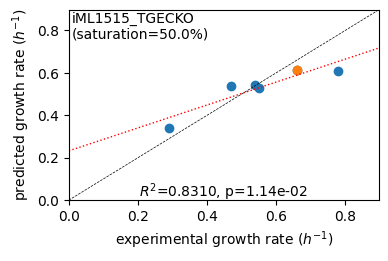

Protein mass fractions:
Acetate                  : r² = 0.2511, p = 1.25e-64 ( 999 proteins lin scale)
Glycerol                 : r² = 0.2292, p = 2.25e-58 ( 999 proteins lin scale)
Fructose                 : r² = 0.6175, p = 2.70e-210 ( 999 proteins lin scale)
Glucose                  : r² = 0.8698, p = 0.00e+00 ( 999 proteins lin scale)
Acetate                  : r² = 0.5130, p = 4.74e-50 ( 310 proteins log scale)
Glycerol                 : r² = 0.4923, p = 5.47e-48 ( 315 proteins log scale)
Fructose                 : r² = 0.5382, p = 6.21e-53 ( 306 proteins log scale)
Glucose                  : r² = 0.5659, p = 1.16e-58 ( 315 proteins log scale)



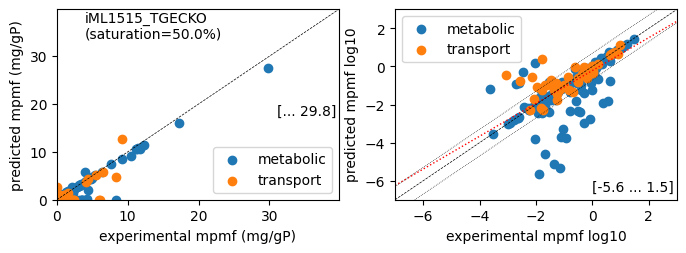

1 file(s) exported for "Load reaction data" into Escher maps
1 file(s) exported for "Load metabolite data" into Escher maps
Duration: 22.3 s


In [4]:
# Optimize model using cobrapy and analyze results
start = time.time()
pred_results = {}
for cond, medium in conditions.items():
    with ecm as model:

        model.medium = medium 
        solution = model.optimize()
        if solution.status == 'optimal':
            gr = solution.objective_value
            pred_results[cond] = solution
            print(f'{cond:25s}: pred gr: {gr:.3f} h-1 vs. exp {exp_grs[cond]:.3f}, '
                  f'diff: {gr - exp_grs[cond]:6.3f}')
        else:    
            print(f'{cond} ended with status {solution.status}')
            
er = EcmResults(eo, pred_results, df_mpmf)
df_fluxes = er.collect_fluxes()
df_net_fluxes = er.collect_fluxes(net=True)
df_proteins = er.collect_protein_results()
er.plot_grs(exp_grs, highlight=reference_cond)
print(f'Protein mass fractions:')
er.report_proteomics_correlation(scale='lin')
er.report_proteomics_correlation(scale='log')
print()
er.plot_proteins(reference_cond)  
df_species_conc = er.collect_species_conc()
er.save_to_escher(df_net_fluxes[reference_cond], os.path.join('escher', target_model))
er.save_to_escher(df_species_conc[reference_cond], os.path.join('escher', target_model))
print(f'Duration: {time.time()-start:.1f} s')

In [5]:
# selected species concentrations
df_species_conc.loc[list(metabolite_molar_concs)].head()

,name,rank,mean mmol_per_l,stdev,Acetate,Glycerol,Fructose,L-Malate,Glucose,Glucose 6-Phosphate
sid,,,,,,,,,,
atp_c,ATP C10H12N5O13P3,1240,1.7800,0.000000e+00,1.780,1.780,1.7800,1.780,1.780,1.7800
adp_c,ADP C10H12N5O10P2,1270,0.2320,0.000000e+00,0.232,0.232,0.2320,0.232,0.232,0.2320
datp_c,DATP C10H12N5O12P3,1269,0.2715,1.402020e-01,0.362,0.362,0.0905,0.362,0.362,0.0905
ctp_c,CTP C9H12N3O14P3,1248,0.6500,0.000000e+00,0.650,0.650,0.6500,0.650,0.650,0.6500
dctp_c,DCTP C9H12N3O13P3,1284,0.0920,1.520235e-17,0.092,0.092,0.0920,0.092,0.092,0.0920


## (Optional) Track progress

In [6]:
import scipy
import numpy as np

number = 8
xy = np.array([[df_mpmf.at[gene, reference_cond], df_proteins.at[gene, reference_cond]] 
                for gene in df_proteins.index if gene in df_mpmf.index])
log10_x, log10_y = er.get_log10_xy(xy)
lin_pearson_r, _ = scipy.stats.pearsonr(xy[:, 0], xy[:, 1])
log_pearson_r, _ = scipy.stats.pearsonr(log10_x, log10_y)

predictions = load_parameter_file('protein_predictions.xlsx')
data = [[number, target_model, lin_pearson_r**2,log_pearson_r**2, len(xy), len(log10_x)]]
cols = ['No', 'model', 'lin r2', 'log r2', 'lin proteins', 'log proteins']
df = pd.DataFrame(data, columns=cols).set_index('No')
if number in predictions[reference_cond].index:
    predictions[reference_cond].drop(index=number, inplace=True)
predictions[reference_cond
] = pd.concat((predictions[reference_cond], df)).sort_index()
write_parameter_file('protein_predictions.xlsx', predictions)
predictions[reference_cond]

1 table(s) with parameters loaded from protein_predictions.xlsx (Thu Nov 20 19:10:13 2025)
1 table(s) with parameters written to  protein_predictions.xlsx


,model,lin r2,log r2,lin proteins,log proteins
No,,,,,
1,iML1515_default_GECKO,0.033244,0.190225,1018,299
2,iML1515_modified_GECKO,0.135981,0.201613,999,322
3,iML1515_predicted_GECKO,0.078803,0.268769,999,308
4,iML1515_manual_adjust_GECKO,0.205413,0.333470,999,308
5,iML1515_predicted_fit_GECKO,0.869850,0.549757,999,313
6,iML1515_RBA,0.852647,0.490353,1112,425
8,iML1515_TGECKO,0.869849,0.565869,999,315


---
---
## (Alternative) gurobipy - model optimization

In [7]:
# Load TGECKO model using gurobipy
start = time.time()
fname = os.path.join('SBML_models', f'{target_model}.xml')
eo = EcmOptimization(fname)

# Set nucleotide concentrations (optional)
orig_concs = eo.set_tfa_metab_concentrations(metabolite_molar_concs)
print(f'{len(orig_concs)} metabolite concentrations constrained')
print(f'Duration: {time.time()-start:.1f} s')

SBML model loaded by sbmlxdf: SBML_models/iML1515_TGECKO.xml (Fri Nov 21 11:40:58 2025)
MILP Model of iML1515_TFA_GECKO
14968 variables, 10593 constraints, 53961 non-zero matrix coefficients
1834 TD reaction constraints
13 metabolite concentrations constrained
Duration: 15.9 s


Acetate                  : pred gr: 0.341 h-1 vs. exp 0.290, diff:  0.051
Glycerol                 : pred gr: 0.540 h-1 vs. exp 0.470, diff:  0.070
Fructose                 : pred gr: 0.544 h-1 vs. exp 0.540, diff:  0.004
L-Malate                 : pred gr: 0.526 h-1 vs. exp 0.550, diff: -0.024
Glucose                  : pred gr: 0.613 h-1 vs. exp 0.660, diff: -0.047
Glucose 6-Phosphate      : pred gr: 0.608 h-1 vs. exp 0.780, diff: -0.172


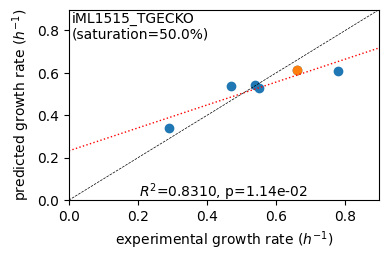

Protein mass fractions:
Acetate                  : r² = 0.2511, p = 1.25e-64 ( 999 proteins lin scale)
Glycerol                 : r² = 0.2292, p = 2.25e-58 ( 999 proteins lin scale)
Fructose                 : r² = 0.6175, p = 2.70e-210 ( 999 proteins lin scale)
Glucose                  : r² = 0.8699, p = 0.00e+00 ( 999 proteins lin scale)
Acetate                  : r² = 0.4610, p = 6.54e-44 ( 315 proteins log scale)
Glycerol                 : r² = 0.4923, p = 5.47e-48 ( 315 proteins log scale)
Fructose                 : r² = 0.5382, p = 6.21e-53 ( 306 proteins log scale)
Glucose                  : r² = 0.5621, p = 1.98e-58 ( 317 proteins log scale)



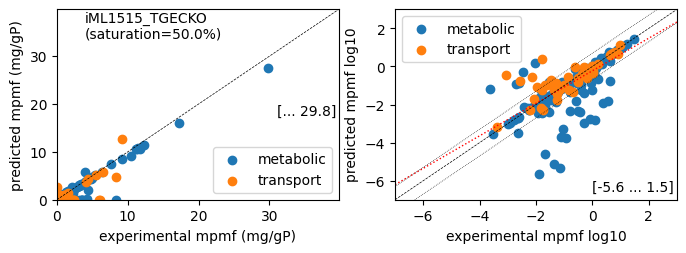

1 file(s) exported for "Load reaction data" into Escher maps
1 file(s) exported for "Load metabolite data" into Escher maps
Duration: 6.2 s


In [8]:
# Optimize model using gurobipy and analyze results
start = time.time()
pred_results = {}
for cond, medium in conditions.items():
    eo.medium = medium
    solution = eo.optimize()

    if solution.status == 'optimal':
        pred_results[cond] = solution
        gr = solution.objective_value
        print(f'{cond:25s}: pred gr: {gr:.3f} h-1 vs. exp {exp_grs[cond]:.3f}, diff: {gr - exp_grs[cond]:6.3f}')
    else:    
        print(f'{cond} ended with status {solution.status}')

er = EcmResults(eo, pred_results, df_mpmf)
df_fluxes = er.collect_fluxes()
df_net_fluxes = er.collect_fluxes(net=True)
df_proteins = er.collect_protein_results()
er.plot_grs(exp_grs, highlight=reference_cond)
print(f'Protein mass fractions:')
er.report_proteomics_correlation(scale='lin')
er.report_proteomics_correlation(scale='log')
print()
er.plot_proteins(reference_cond)  
df_species_conc = er.collect_species_conc()
er.save_to_escher(df_net_fluxes[reference_cond], os.path.join('escher', target_model))
er.save_to_escher(df_species_conc[reference_cond], os.path.join('escher', target_model))
print(f'Duration: {time.time()-start:.1f} s')

In [9]:
df_species_conc.loc[list(metabolite_molar_concs)].head()

,name,rank,mean mmol_per_l,stdev,Acetate,Glycerol,Fructose,L-Malate,Glucose,Glucose 6-Phosphate
sid,,,,,,,,,,
atp_c,ATP C10H12N5O13P3,368,3.5600,2.757564e+00,7.1200,7.1200,1.7800,1.7800,1.7800,1.7800
adp_c,ADP C10H12N5O10P2,445,0.1740,8.985321e-02,0.0580,0.0580,0.2320,0.2320,0.2320,0.2320
datp_c,DATP C10H12N5O12P3,464,0.0905,1.520235e-17,0.0905,0.0905,0.0905,0.0905,0.0905,0.0905
ctp_c,CTP C9H12N3O14P3,446,0.1625,3.040471e-17,0.1625,0.1625,0.1625,0.1625,0.1625,0.1625
dctp_c,DCTP C9H12N3O13P3,463,0.0920,1.520235e-17,0.0920,0.0920,0.0920,0.0920,0.0920,0.0920


In [10]:
df_species_conc.loc[['ac_c', 'ac_p']].head()

,name,rank,mean mmol_per_l,stdev,Acetate,Glycerol,Fructose,L-Malate,Glucose,Glucose 6-Phosphate
sid,,,,,,,,,,
ac_c,Acetate,516,0.015653,0.038317,0.093868,0.00001,0.00001,0.00001,0.00001,0.00001
ac_p,Acetate,491,0.032806,0.080332,0.196783,0.00001,0.00001,0.00001,0.00001,0.00001
